In [2]:
%load_ext autoreload
%autoreload 2

import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes
from pymfr.reconstruct import reconstruct_map


In [3]:
torch.cuda.device_count()

1

In [4]:
time = ['2016-01-01T00:00:00Z', '2016-02-01T00:00:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz".replace(':', '-')
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = data.Epoch.values

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = data.Epoch.values
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [8]:
window_lengths = range(10, 360)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=10000,
                            window_steps=[1] * len(window_lengths),
                            window_lengths=window_lengths,
                            sample_spacing=60,
                            n_trial_axes=256,
                            threshold_diff=0.3,
                            threshold_fit=0.2,
                            max_processing_resolution=32,
                            cuda=True)



100%|██████████| 350/350 [00:48<00:00,  7.21it/s]


In [9]:
len(results.event)

426

2016-01-01T03:21:30.000000000  to  2016-01-01T03:31:30.000000000
window length: 10
duration: 10.0
error: 0.25 0.068
walen slope: -0.113
alfvenicity: -0.113
<B>: 13.22
Altitude/azimuth: 163 / 6
Frame quality: 0.999991238117218
Field alignment -0.9945046901702881


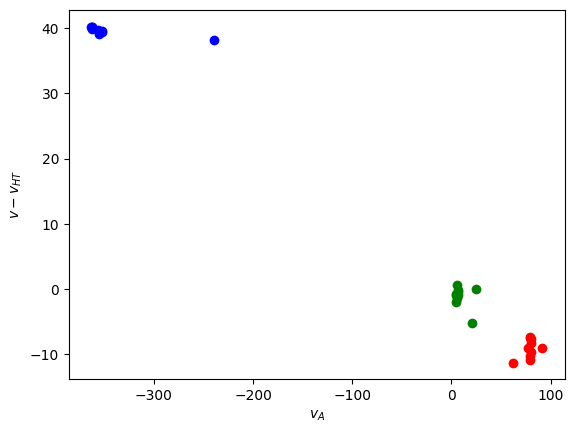

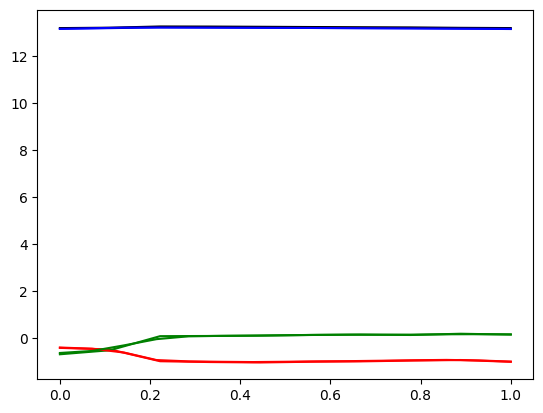

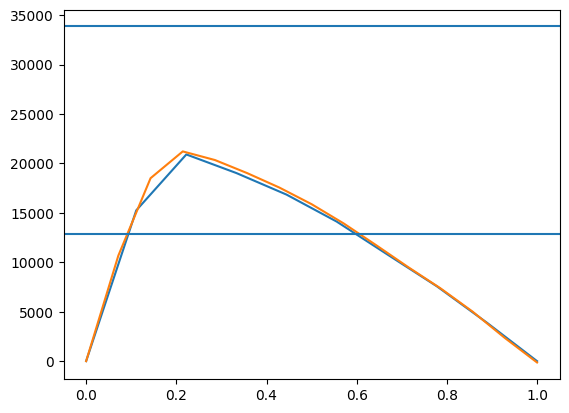

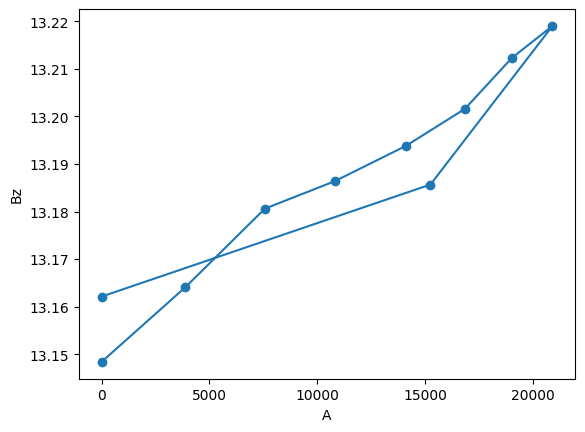

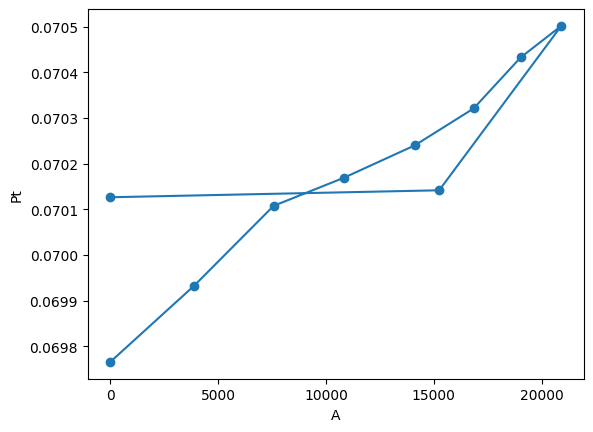

closed % 17
width 0.8666666666666667
height 0.26666666666666666
poloidal flux per au 3152.0126953125
axial flux 318.799314944
twist per au 9.887137605255456
field line length 0.10114150727187769
<xarray.DataArray 'spatial_scale' ()>
array(0.00165795)
scale in au 0.0010353916234049942


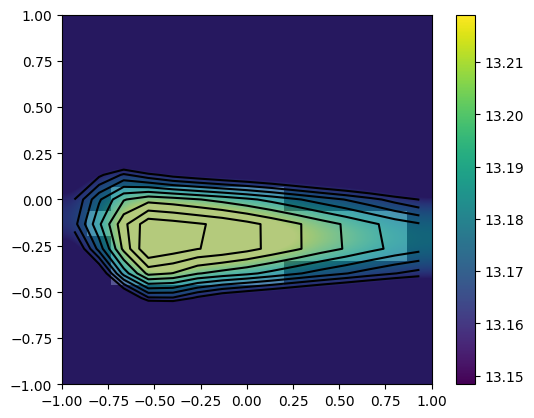

2016-01-01T05:34:30.000000000  to  2016-01-01T05:49:30.000000000
window length: 15
duration: 15.0
error: 0.227 0.128
walen slope: 0.455
alfvenicity: 0.455
<B>: 9.81
Altitude/azimuth: 111 / 285
Frame quality: 0.99998539686203
Field alignment 0.9981438517570496


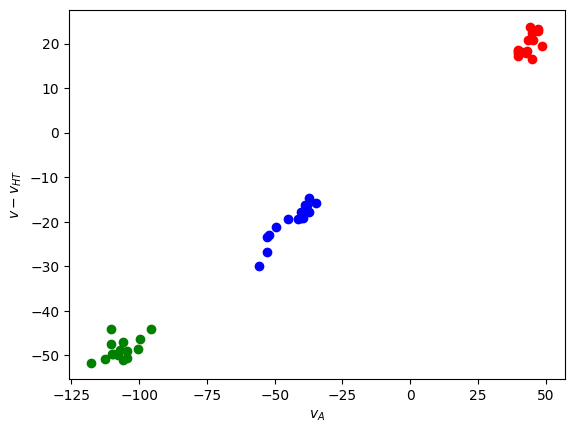

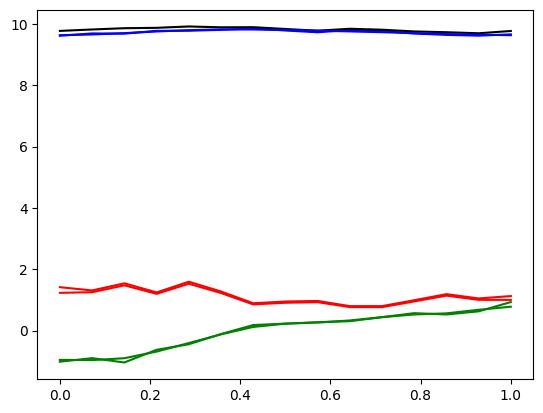

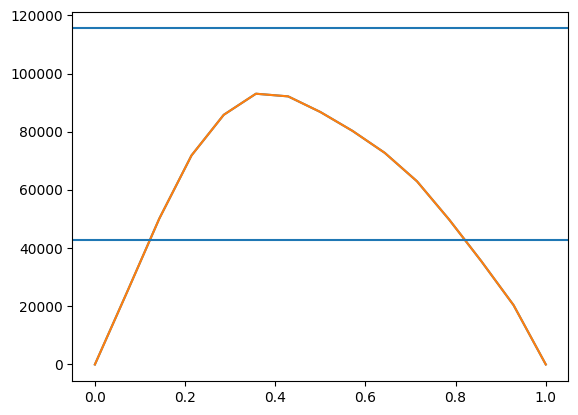

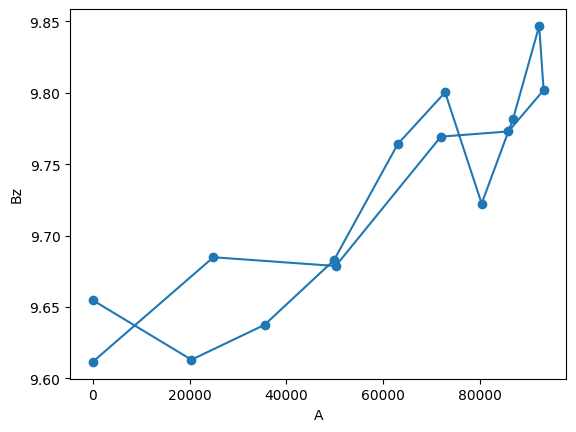

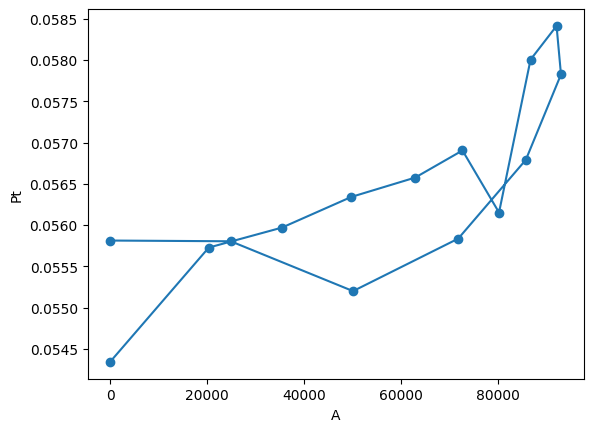

closed % 21
width 0.8666666666666667
height 0.3333333333333333
poloidal flux per au 10897.109765625
axial flux 326.38910464
twist per au 33.38686742513747
field line length 0.029951896572575278
<xarray.DataArray 'spatial_scale' ()>
array(0.00261247)
scale in au 0.0012191538208007812


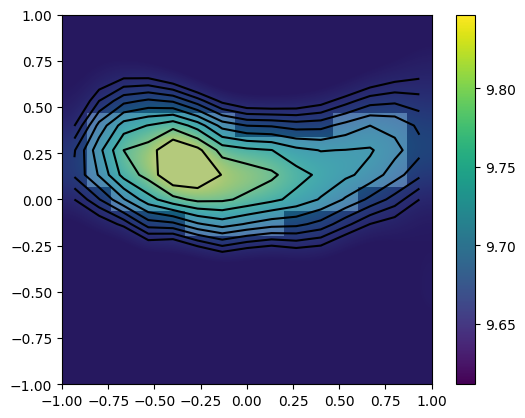

2016-01-01T06:15:30.000000000  to  2016-01-01T06:59:30.000000000
window length: 44
duration: 44.0
error: 0.249 0.126
walen slope: -0.249
alfvenicity: -0.264
<B>: 10.88
Altitude/azimuth: 152 / 289
Frame quality: 0.9999068379402161
Field alignment -0.9299925565719604


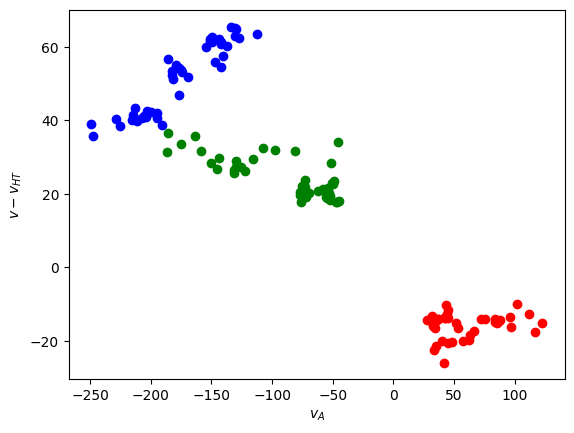

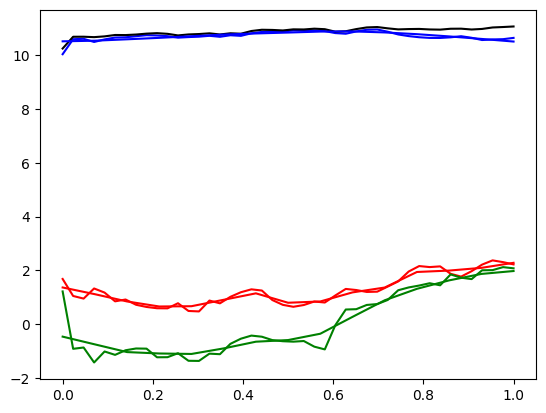

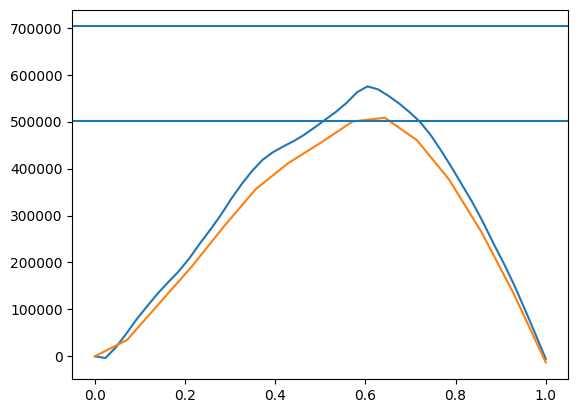

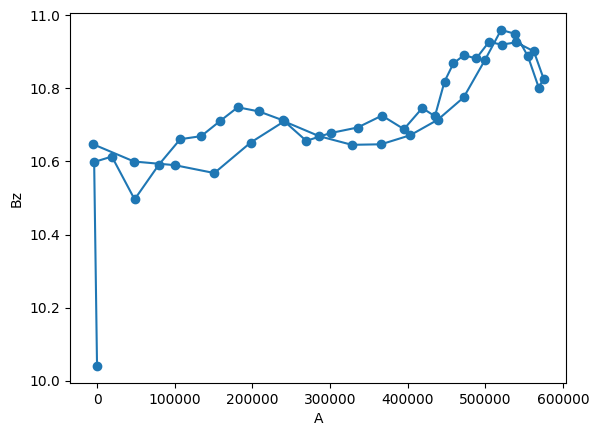

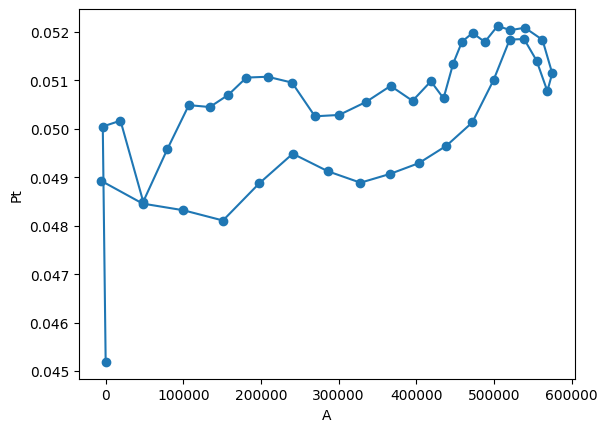

closed % 12
width 0.3333333333333333
height 0.4666666666666667
poloidal flux per au 30367.968750000004
axial flux 205.454032896
twist per au 147.80906620300877
field line length 0.006765484862928146
<xarray.DataArray 'spatial_scale' ()>
array(0.00745826)
scale in au 0.0009128171857199655


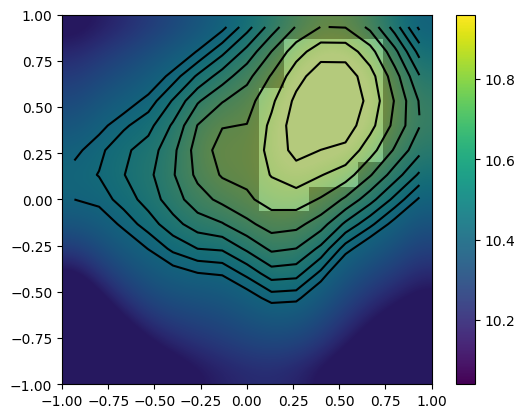

2016-01-01T07:33:30.000000000  to  2016-01-01T11:23:30.000000000
window length: 230
duration: 230.0
error: 0.157 0.096
walen slope: -0.093
alfvenicity: -0.098
<B>: 9.83
Altitude/azimuth: 93 / 289
Frame quality: 0.998880922794342
Field alignment -0.7408691644668579


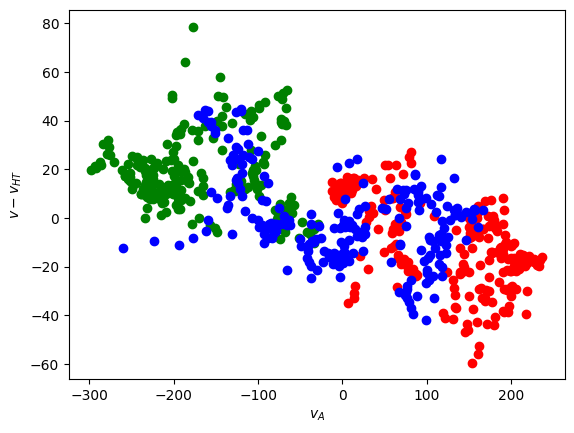

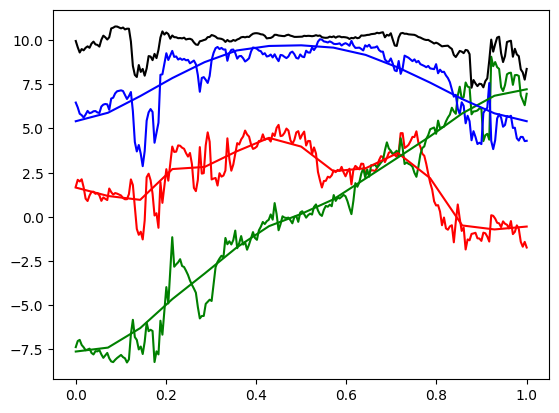

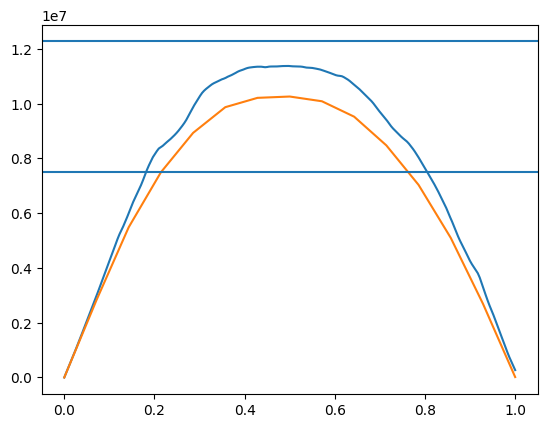

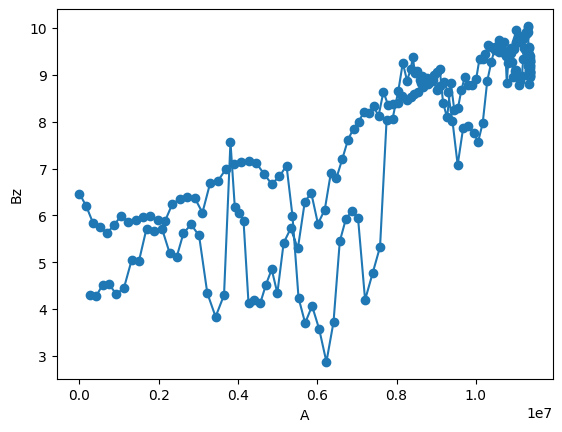

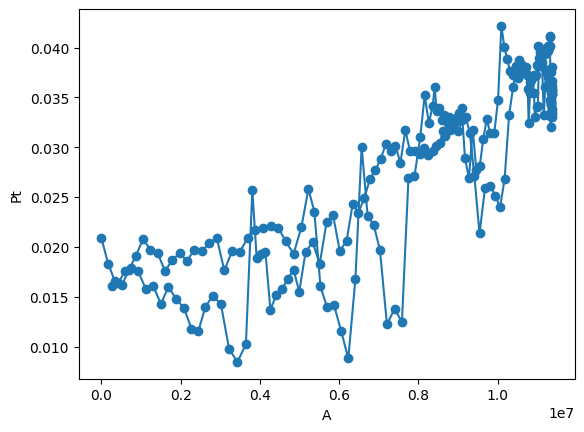

closed % 28
width 0.6
height 0.5333333333333333
poloidal flux per au 716585.25
axial flux 349.45122304
twist per au 2050.60163694999
field line length 0.0004876617583741781
<xarray.DataArray 'spatial_scale' ()>
array(0.03708247)
scale in au 0.00128982509765625


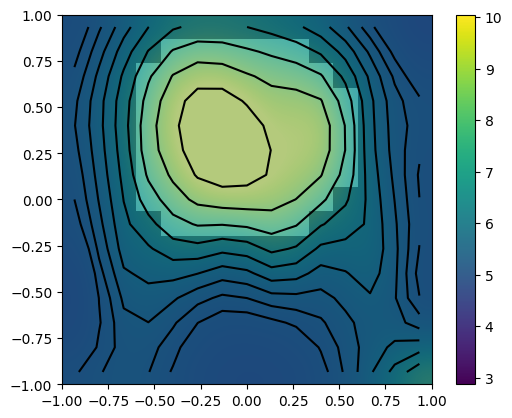

2016-01-01T11:59:30.000000000  to  2016-01-01T12:51:30.000000000
window length: 52
duration: 52.0
error: 0.174 0.153
walen slope: 0.313
alfvenicity: 0.316
<B>: 9.74
Altitude/azimuth: 103 / 317
Frame quality: 0.998794674873352
Field alignment 0.9255639314651489


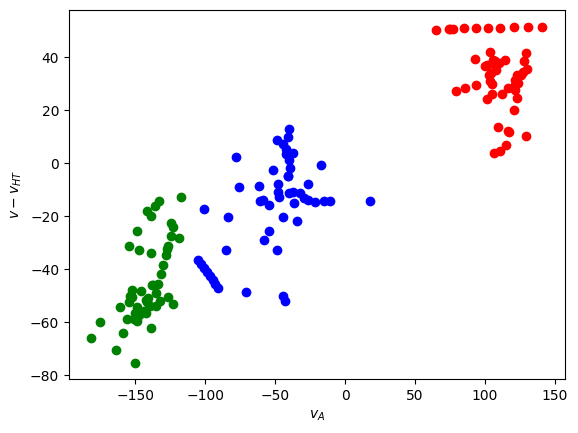

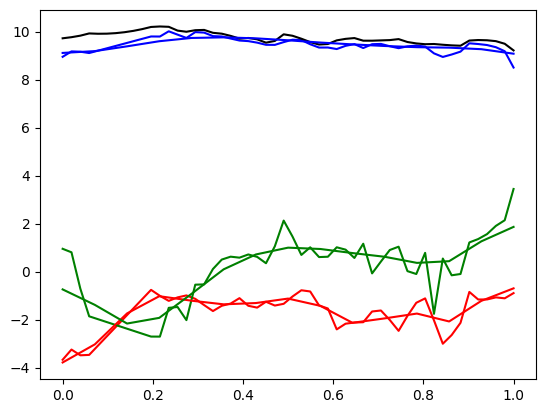

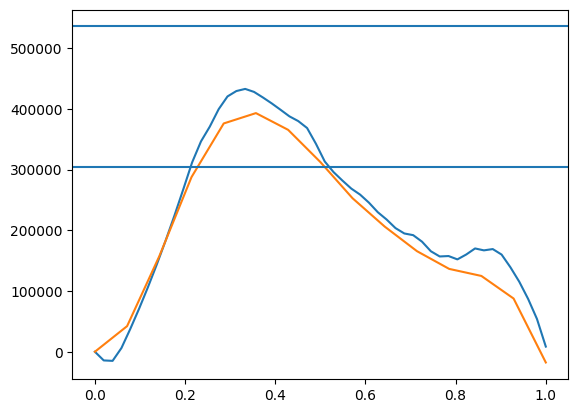

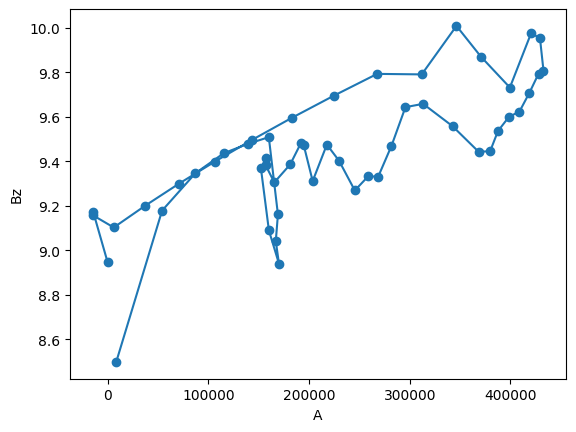

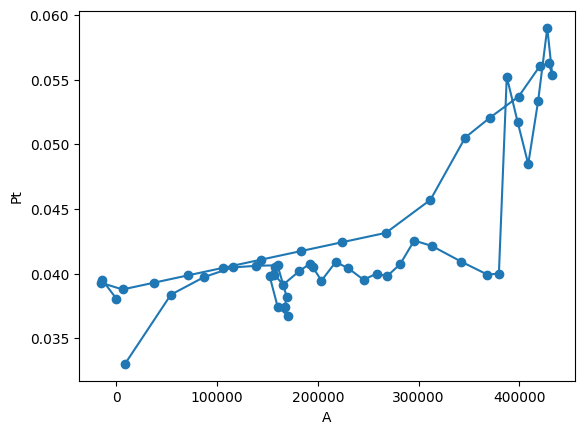

closed % 11
width 0.3333333333333333
height 0.4666666666666667
poloidal flux per au 34598.484375
axial flux 67.76172544
twist per au 510.59036868291406
field line length 0.001958517162357636
<xarray.DataArray 'spatial_scale' ()>
array(0.00566234)
scale in au 0.0005552379114779362


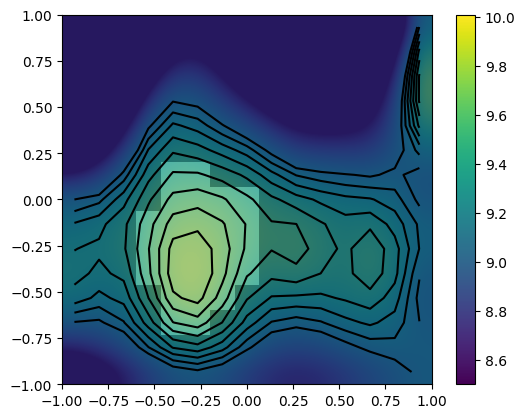

2016-01-01T13:33:30.000000000  to  2016-01-01T13:57:30.000000000
window length: 24
duration: 24.0
error: 0.197 0.083
walen slope: 0.009
alfvenicity: 0.009
<B>: 9.16
Altitude/azimuth: 99 / 317
Frame quality: 0.9999148845672607
Field alignment 0.3891456425189972


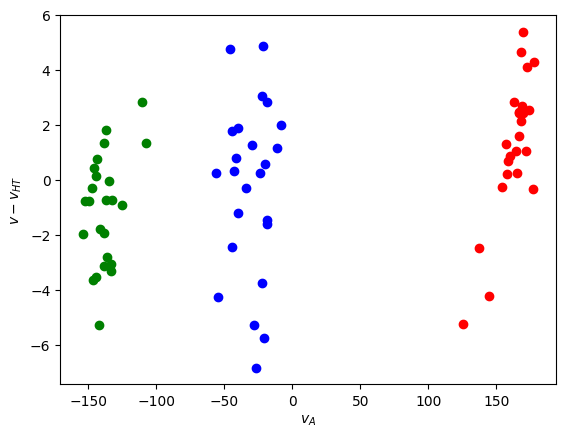

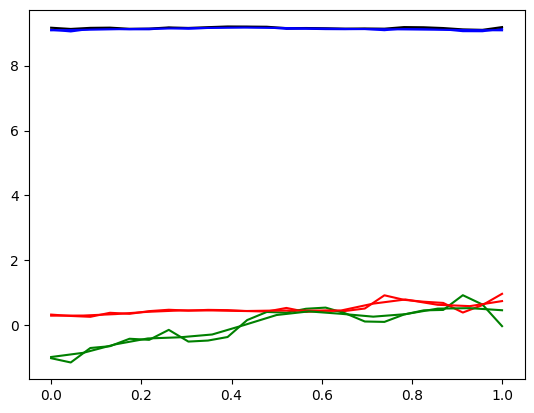

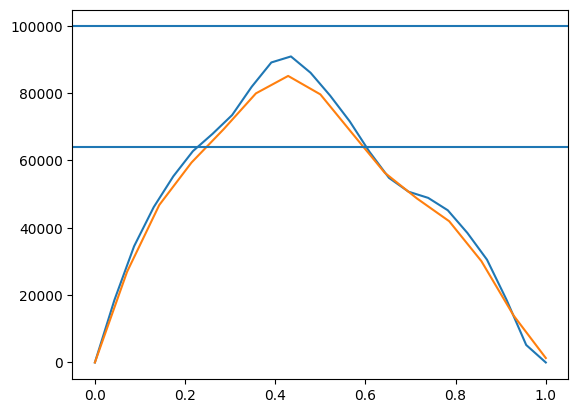

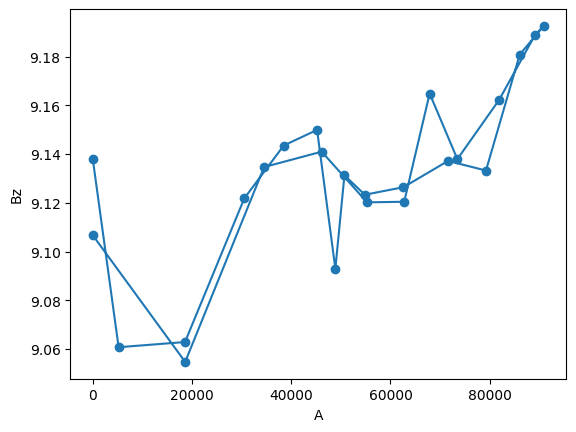

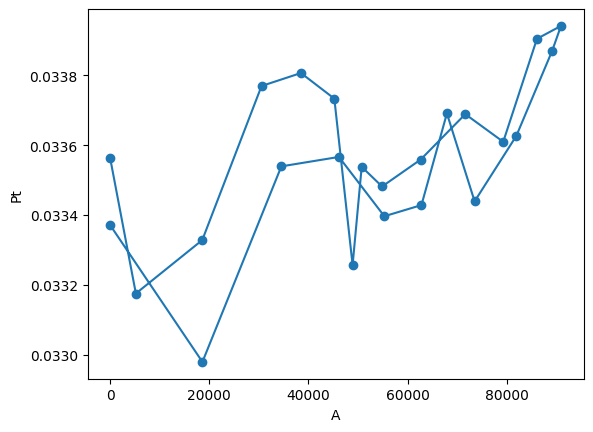

closed % 12
width 0.4
height 0.4
poloidal flux per au 5384.8927734375
axial flux 75.57024153600001
twist per au 71.25678923326261
field line length 0.014033750478518627
<xarray.DataArray 'spatial_scale' ()>
array(0.00274586)
scale in au 0.0006054062279362729


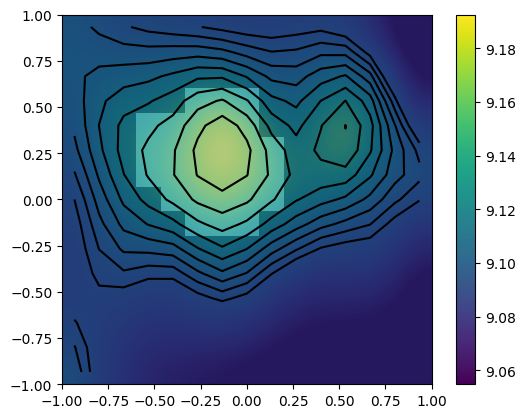

2016-01-01T14:07:30.000000000  to  2016-01-01T14:17:30.000000000
window length: 10
duration: 10.0
error: 0.295 0.107
walen slope: 0.147
alfvenicity: 0.147
<B>: 9.18
Altitude/azimuth: 99 / 327
Frame quality: 0.9999902248382568
Field alignment 0.9988564252853394


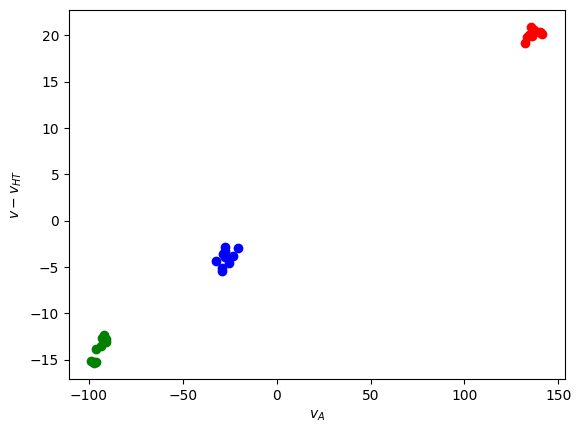

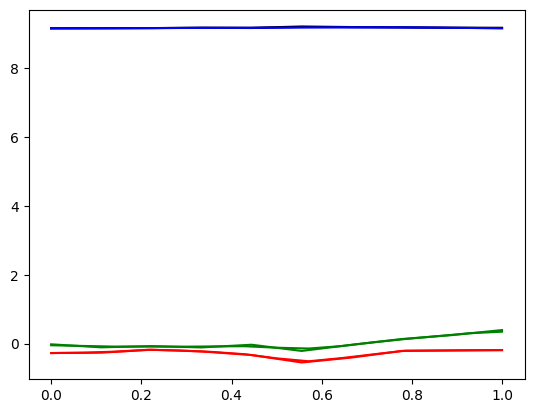

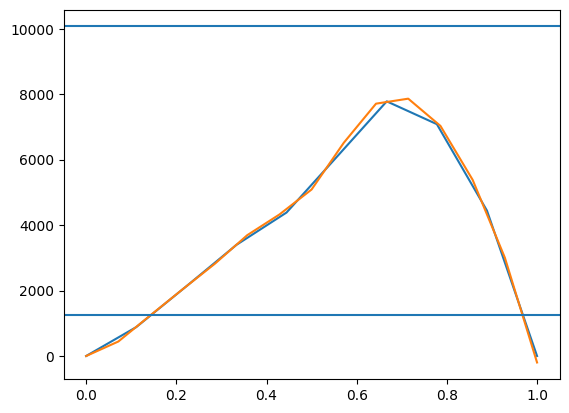

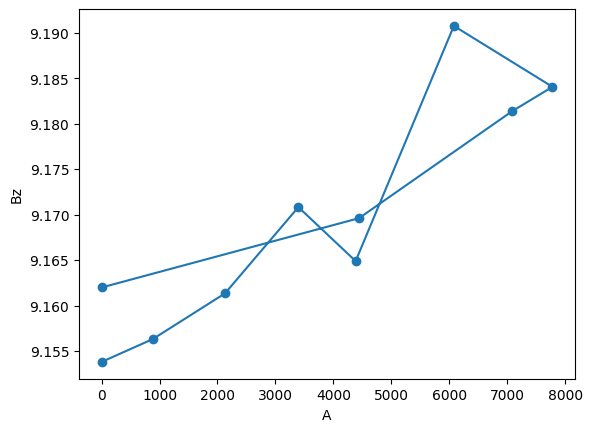

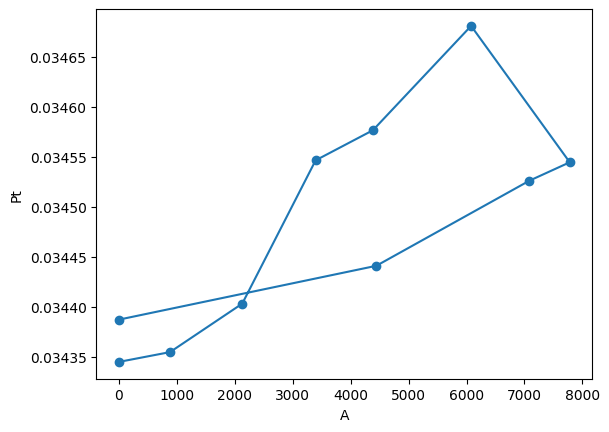

closed % 18
width 0.8666666666666667
height 0.3333333333333333
poloidal flux per au 1323.308203125
axial flux 72.272248832
twist per au 18.310046034420317
field line length 0.05461482718940959
<xarray.DataArray 'spatial_scale' ()>
array(0.00092413)
scale in au 0.0005917305945070671


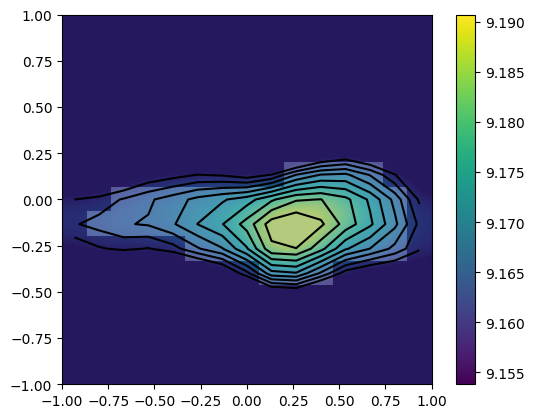

2016-01-01T14:24:30.000000000  to  2016-01-01T16:03:30.000000000
window length: 99
duration: 99.0
error: 0.22 0.107
walen slope: 0.079
alfvenicity: 0.079
<B>: 8.99
Altitude/azimuth: 89 / 310
Frame quality: 0.9997267127037048
Field alignment 0.829660177230835


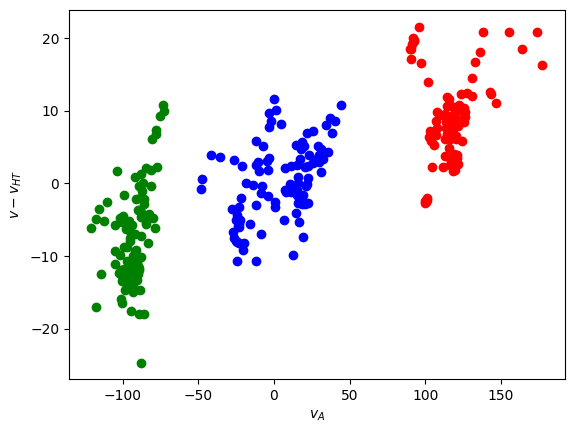

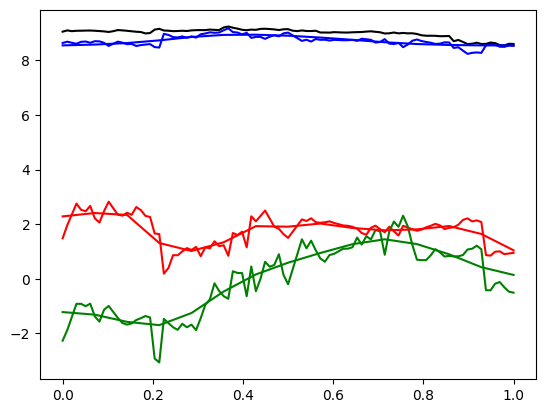

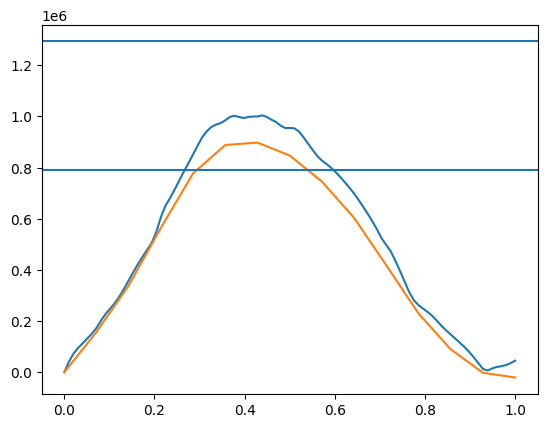

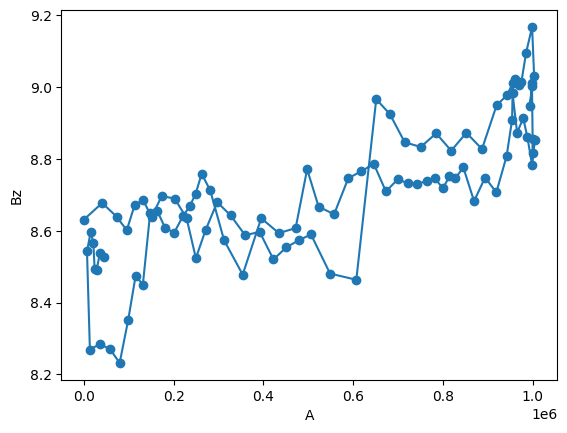

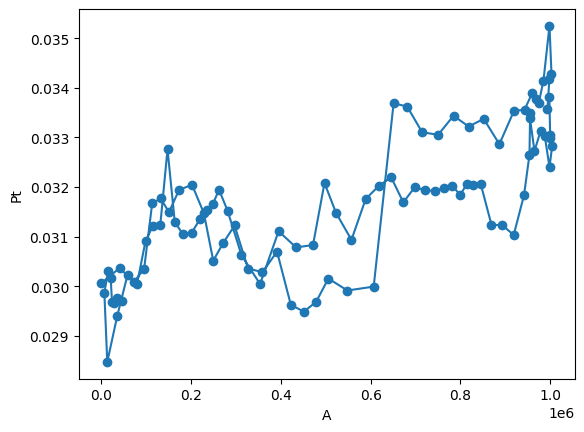

closed % 15
width 0.4
height 0.4666666666666667
poloidal flux per au 75244.90312500001
axial flux 117.88993331200001
twist per au 638.2640231533733
field line length 0.001566749752021825
<xarray.DataArray 'spatial_scale' ()>
array(0.01292365)
scale in au 0.0007611835072736876


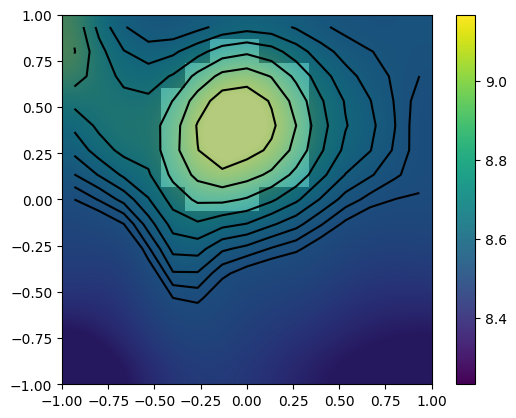

2016-01-01T16:06:30.000000000  to  2016-01-01T16:27:30.000000000
window length: 21
duration: 21.0
error: 0.182 0.198
walen slope: 0.265
alfvenicity: 0.265
<B>: 8.26
Altitude/azimuth: 92 / 297
Frame quality: 0.9993962049484253
Field alignment 0.9425235986709595


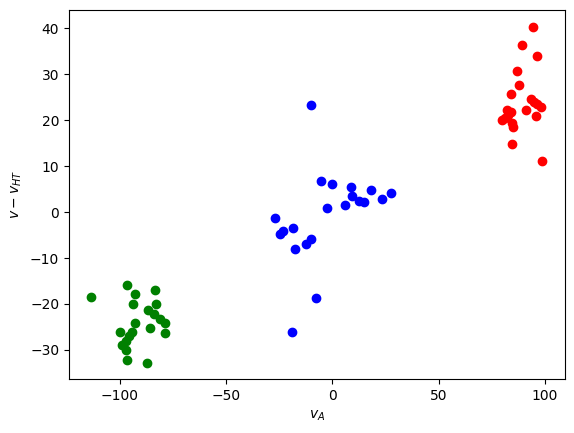

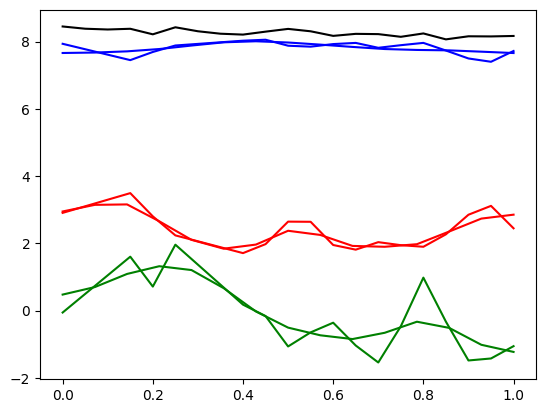

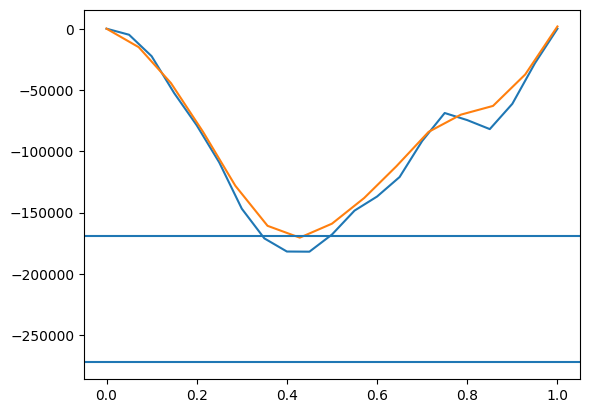

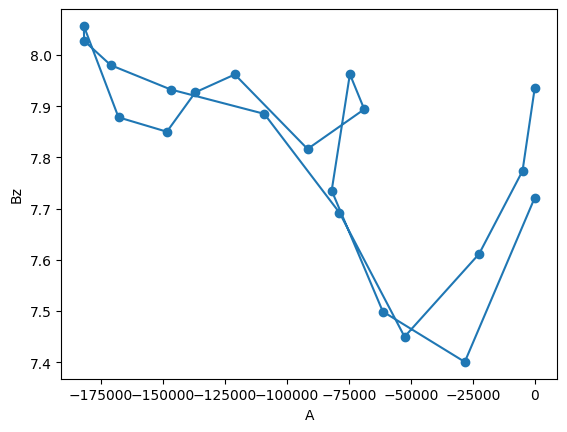

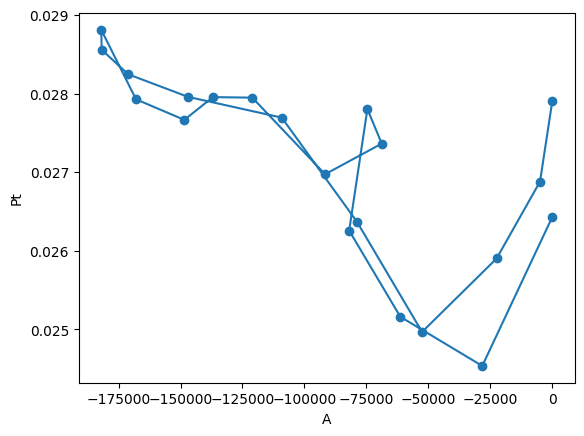

closed % 17
width 0.6
height 0.4
poloidal flux per au 15435.447656250002
axial flux 164.440244224
twist per au 93.86660625013353
field line length 0.010653415947895501
<xarray.DataArray 'spatial_scale' ()>
array(0.00317932)
scale in au 0.0009454696746260293


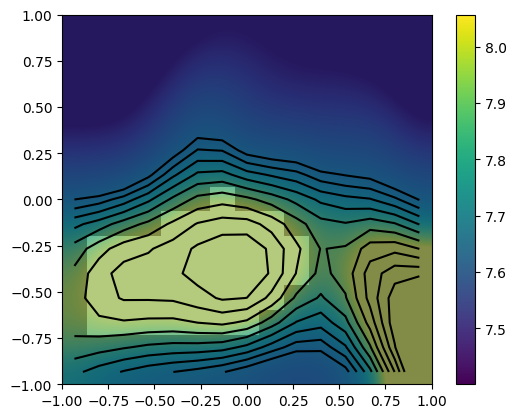

2016-01-01T17:00:30.000000000  to  2016-01-01T17:14:30.000000000
window length: 14
duration: 14.0
error: 0.195 0.103
walen slope: 0.594
alfvenicity: 0.594
<B>: 8.17
Altitude/azimuth: 92 / 310
Frame quality: 0.9998973608016968
Field alignment 0.9940742254257202


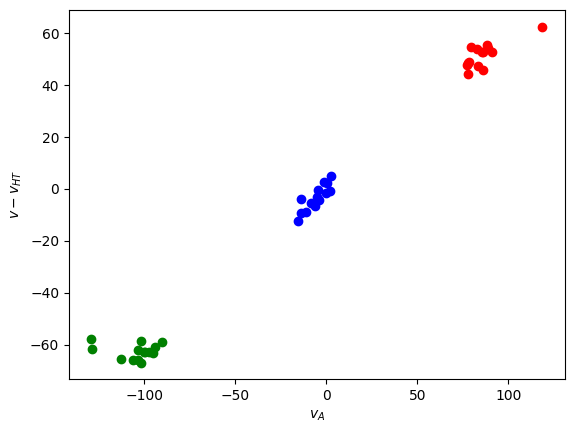

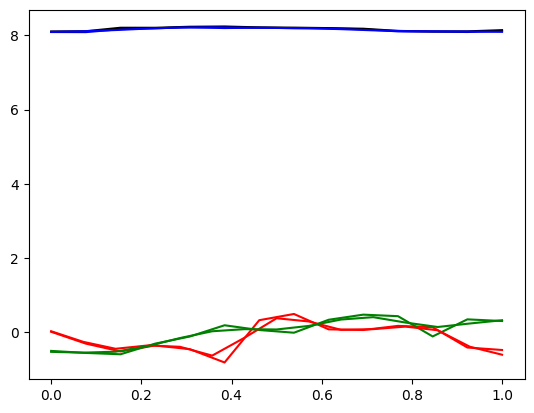

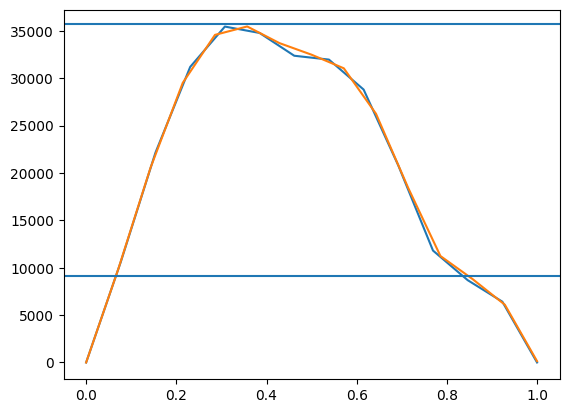

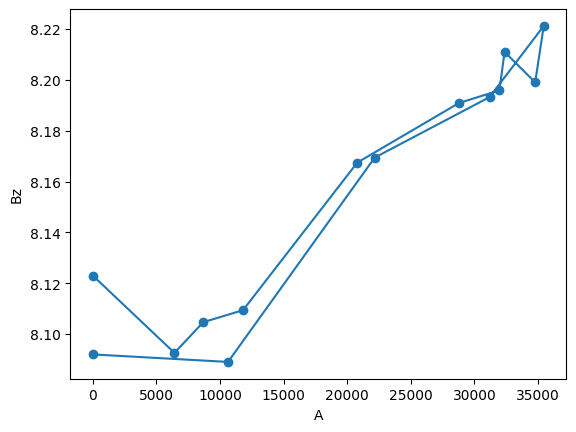

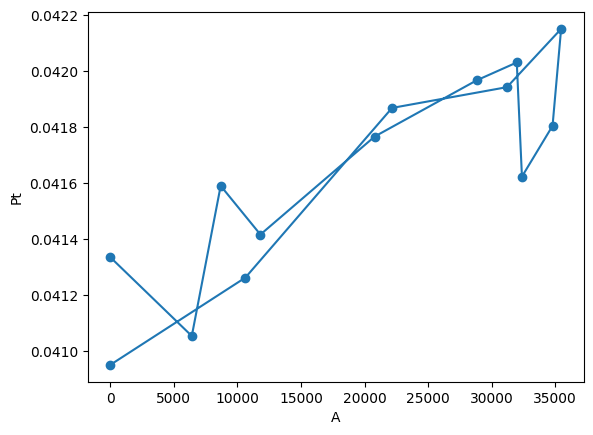

closed % 13
width 0.7333333333333333
height 0.26666666666666666
poloidal flux per au 3984.2162109375
axial flux 100.30732902400001
twist per au 39.72009074216518
field line length 0.025176176119316915
<xarray.DataArray 'spatial_scale' ()>
array(0.00185929)
scale in au 0.0007394364206484167


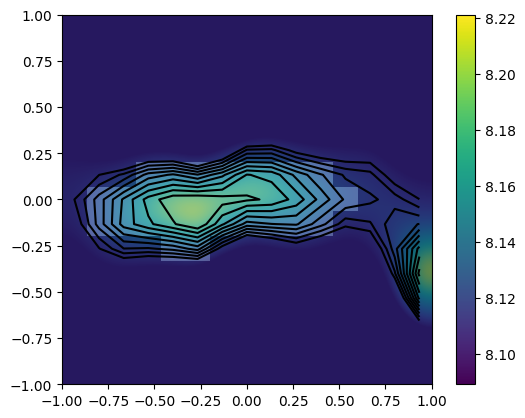

In [10]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_event in list(sorted(results.event, reverse=False, key=lambda x: results.window_start.sel(event=x)))[:10]:
    event = results.sel(event=i_event)
    axis = event[["axis_x", "axis_y", "axis_z"]].to_array().values
    propagation_velocity = event[["velocity_x", "velocity_y", "velocity_z"]].to_array().values
    window_start = event.window_start.item()
    window_length = event.window_length.item()
    temporal_scale = event.temporal_scale.item()
    residue = event.residue_diff.item()
    error_fit = event.residue_fit.item()

    event_flow_velocity = velocity[window_start:window_start + window_length].cpu().numpy()
    event_magnetic_field = magnetic_field[window_start:window_start + window_length].cpu().numpy()
    event_density = density[window_start:window_start + window_length].cpu().numpy()
    Pgas = gas_pressure[window_start:window_start + window_length].cpu().numpy()

    x_unit = -(propagation_velocity - np.dot(propagation_velocity, axis) * axis)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(axis, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, axis])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix
    alfven_velocity = event_magnetic_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_flow_velocity - propagation_velocity

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[window_start], " to ", times[window_start + window_length])
    print("window length:", window_length)
    print("duration:", temporal_scale / 60)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("alfvenicity:", round(event.walen_slope.item(), 3))
    print("<B>:", round(np.linalg.norm(event_magnetic_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", event.frame_quality.item())
    print("Field alignment", event.flow_field_alignment.item())

    rotated = rotation_matrix @ event_magnetic_field.T

    dx = np.linalg.norm(np.dot(propagation_velocity, x_unit)) * 60
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0, dx=dx)
    alpha = event.walen_slope.item() ** 2
    Pt = Pgas / (1 - alpha) + ((rotated[2] * 1e-9) ** 2 + (alpha / (1 - alpha)) * (np.linalg.norm(rotated, axis=0)* 1e-9) ** 2) / (2 * 1.25663706212e-6) * 1e9

    colors = ["red", "green", "blue"]

    A_peak = A[np.abs(A).argmax()]
    A_sign = np.sign(A_peak)

    map_core_mask = event.map_core_mask.values
    map_A = event.map_Az.values
    
    closed_min = (map_A[map_core_mask] * A_sign).min()
    closed_max = (map_A[map_core_mask] * A_sign).max()

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    plt.show()

    for i_color, color in enumerate(colors):
        plt.plot(np.linspace(0, 1, len(rotated[i_color])), rotated[i_color], color=color)
    plt.plot(np.linspace(0, 1, len(rotated[0])), np.linalg.norm(rotated, axis=0), color="black")


    plt.plot(np.linspace(0, 1, 15), event.map_Bx[event.map_Bx.shape[0] // 2, :], color="red")
    plt.plot(np.linspace(0, 1, 15), event.map_By[event.map_By.shape[0] // 2, :], color="green")
    plt.plot(np.linspace(0, 1, 15), event.map_Bz[event.map_Bz.shape[0] // 2, :], color="blue")
    
    plt.show()
    plt.plot(np.linspace(0, 1, len(A)), A)
    plt.plot(np.linspace(0, 1, 15), map_A[map_A.shape[0] // 2, :])
    plt.axhline(closed_min * A_sign)
    plt.axhline(closed_max * A_sign)
    plt.show()

    plt.scatter(A, rotated[2])
    plt.plot(A, rotated[2])
    plt.xlabel("A")
    plt.ylabel("Bz")
    plt.show()

    plt.scatter(A, Pt)
    # plt.ylim(0, Pt.max() * 1.5)
    plt.plot(A, Pt)
    plt.xlabel("A")
    plt.ylabel("Pt")
    plt.show()

    extent = (-1, 1, -1, 1)

    plt.imshow(event.map_Bz, vmin=max(0, rotated[2].min()), vmax=rotated[2].max(), interpolation="bicubic", extent=extent, origin="lower")
    # plt.imshow(map_A / A_peak, vmin=0, cmap="gist_heat", extent=extent, origin="lower")
    plt.colorbar()
    enclosed_levels = (map_A[map_core_mask] * A_sign)
    levels = np.linspace(0, enclosed_levels.max(), 10)
    plt.contour(map_A * A_sign, origin="lower", extent=extent, levels=levels, colors="black", algorithm="serial", antialiased=True)
   
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    

    print("closed %", int(100 * map_core_mask.mean()))
    print("width", np.any(map_core_mask, axis=-2).sum() / 15)
    print("height", np.any(map_core_mask, axis=-1).sum() / 15)

    poloidal_flux = (closed_max - closed_min) * 1e-9 * 1.5e8
    axial_flux = (event.map_Bz.values[map_core_mask] * dx ** 2).sum().item() * 1e-9

    print("poloidal flux per au", poloidal_flux)
    print("axial flux", axial_flux)
    print("twist per au", poloidal_flux / axial_flux)
    print("field line length", axial_flux / poloidal_flux)
    print(event.spatial_scale / 1.5e8)
    print("scale in au", np.sqrt(np.count_nonzero(map_core_mask) * (dx / 1.5e8) ** 2))

    plt.imshow(map_core_mask, vmin=0, vmax=2, origin="lower", extent=extent, cmap="Blues_r", alpha=0.5)


    plt.show()

